In [7]:
import igraph
import matplotlib.pyplot as plt
import numpy as np
from os import path
import pandas as pd
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from sklearn.decomposition import FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from selfregulation.utils.r_to_py_utils import GPArotation, missForest, psychFA
%matplotlib inline

### Load Data

Load both cleaned and imputed data. Set up a helper function to quickly impute data within the Kfold split. Can't use data where imputation was performed over the whole dataset as there will be data leakage between training and test.

In [8]:
datafile = 'Complete_05-13-2017'
# load data
# imputed data
imputed_data = get_behav_data(dataset=datafile, file = 'meaningful_variables_imputed.csv')
imputed_task_data = get_behav_data(dataset=datafile, file = 'taskdata_imputed.csv')
imputed_survey_data = imputed_data.drop(imputed_task_data.columns, axis = 1)
imputed_datasets = {'survey': imputed_survey_data, 'task': imputed_task_data, 'complete': imputed_data}

results = {'survey': {}, 'task': {}, 'complete': {}}

Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_05-13-2017
Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_05-13-2017


Reorder data in some slightly interpretable way

In [9]:
for key, dataset in imputed_datasets.items():
    sorted_columns = []
    survey_cols = ('survey', dataset.filter(regex='survey').columns.tolist())
    drift_cols = ('drift', dataset.filter(regex='\.hddm_drift').columns.tolist())
    drift_contrast_cols = ('drift con', dataset.filter(regex='\..*_hddm_drift').columns.tolist())
    thresh_cols = ('thresh', dataset.filter(regex='\.hddm_thresh').columns.tolist())
    thresh_contrast_cols = ('thresh con', dataset.filter(regex='\..*_hddm_thresh').columns.tolist())
    non_decision_cols = ('non-decision', dataset.filter(regex='\.hddm_non_decision').columns.tolist())
    non_decision_contrast_cols = ('non-decision con', dataset.filter(regex='\..*_hddm_non_decision').columns.tolist())
    stop_cols = ('stop', dataset.filter(regex='stop').columns.tolist())
    discount_cols = ('discount', dataset.filter(regex='discount').columns.tolist())
    leftover_cols = ('misc', dataset.columns)

    tmp_groups = [survey_cols,
                  drift_cols, drift_contrast_cols, 
                  thresh_cols, thresh_contrast_cols,
                  non_decision_cols, non_decision_contrast_cols,
                  stop_cols, discount_cols,
                  leftover_cols]
    putative_groups = []
    results[key]['putative_groups'] = putative_groups
    for name, group in tmp_groups:
        group = sorted(list(set(group)-set(sorted_columns)))
        sorted_columns+=group
        putative_groups.append((name,group))
    imputed_datasets[key] = dataset.reindex_axis(sorted_columns, axis=1)

# Calculate best number of components

### Define Helper functions

In [10]:
def run_FA(n_components,data,cv):
    fa=FactorAnalysis(n_components)
    scores = []
    # cross-validate fit across different train/test splits
    for train_index, test_index in cv.split(data.values):
        data_train, data_test = data.iloc[train_index], \
                                data.iloc[test_index]
        # Impute (replace with missForest later)
        imputed_train = SoftImpute_df(data_train)
        imputed_test = SoftImpute_df(data_test)
        # Scale data
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(imputed_train)
        scaled_test = scaler.transform(imputed_test)
        # fit model on training
        fa.fit(scaled_train)
        # score on test set
        scores.append(fa.score(scaled_test))
    #average score across kfolds
    score = np.mean(scores)
    return score, fa

def find_optimal_components(data, method='sklearn', cv=None):
    if method == 'sklearn':
        assert cv, "Must Supply a CV if using sklearn"
        # find best number of components
        n_components = range(1,20)
        best_c = 0
        component_scores = []
        for c in n_components:
            score, fa = run_FA(c,data,cv)
            component_scores.append(score)
        best_c = np.argmax(component_scores)+1
        print('Best Component: ', best_c)
        return best_c, component_scores
    elif method == 'psych':
        BICs = []
        outputs = []
        n_components = range(1,20)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        for c in n_components:
            fa, output = psychFA(scaled_data, c, method='ml')
            BICs.append(output['BIC'])
            outputs.append(output)
        best_c = np.argmin(BICs)+1
        print('Best Component: ', best_c)
        return best_c, BICs

### Calculate best number of components using BIC (R Psych package)

In [ ]:
for label,data in imputed_datasets.items():
    print('Dataset: %s' % label)
    best_c, BICs = find_optimal_components(data, method='psych')
    results[label]['psych_best_c'] = best_c
    results[label]['psych_BICs'] = BICs


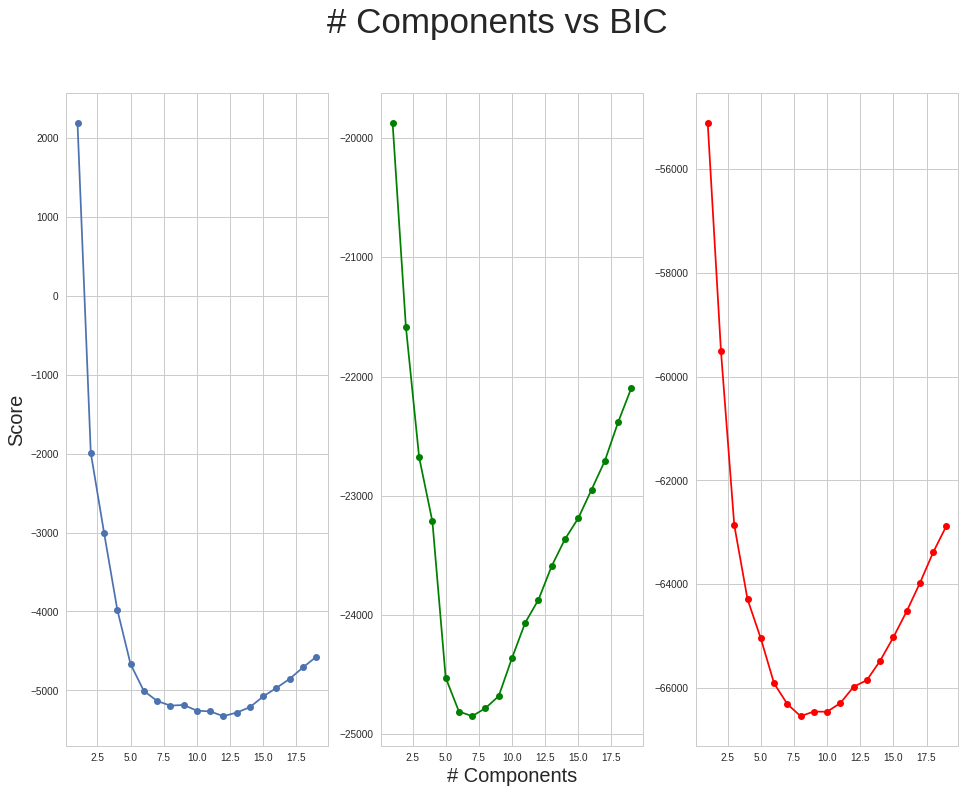

In [150]:
sns.set_style('whitegrid')

fig = plt.figure(figsize=(16,12))
ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=3)
ax2 = plt.subplot2grid((3, 3), (0, 1), rowspan=3)
ax3 = plt.subplot2grid((3, 3), (0, 2), rowspan=3)


plot_data = results['survey']['psych_BICs']
ax1.plot(range(1,len(plot_data)+1),plot_data, '-o')
ax1.set_ylabel('Score', fontsize = 20)

plot_data = results['task']['psych_BICs']
ax2.plot(range(1,len(plot_data)+1),plot_data, '-go')
ax2.set_xlabel('# Components', fontsize = 20)

plot_data = results['complete']['psych_BICs']
ax3.plot(range(1,len(plot_data)+1),plot_data, '-ro')

fig.suptitle('# Components vs BIC', fontsize = 35)

# Interpret Factor Analysis Solutions
Above we found that the best number of components were as follows:

**Psych**:

Task: {{results['task']['psych_best_c']}}

Survey: {{results['survey']['psych_best_c']}}

Complete: {{results['complete']['psych_best_c']}}

First we will look at the best number of components, then we will look at the solution at each dimensionality and plot the relationships between dimensions

### Complete Dataset (Surveys and tasks)


In [168]:
# perform factor analysis
complete_results = results['complete']
best_c = complete_results['psych_best_c']
data = imputed_datasets['complete']
putative_groups = results['complete']['putative_groups']
fa, output = psychFA(data, best_c)

In [172]:
### Print top variables for each factor
def get_loadings(fa_output, labels):
    return pd.DataFrame(fa_output['loadings'], index=labels)

def print_top_factors(loading_df, n = 4):
    # number of variables to display
    for i,column in loading_df.iteritems():
        sort_index = np.argsort(abs(column))[::-1] # descending order
        top_vars = column[sort_index][0:n]
        print('\nFACTOR %s' % i)
        print(top_vars)
        
loading_df = get_loadings(output, labels=data.columns)
print_top_factors(loading_df, 10)
# sort by maximum loading on surveys
sorting_index = np.argsort(loading_df.filter(regex='survey',axis=0).abs().mean()).tolist()[::-1]
loading_df = loading_df.loc[:,sorting_index]
loading_df.columns = range(best_c)

loading_df.loc[:,'task'] = [i.split('.')[0] for i in loading_df.index]


FACTOR 0
self_regulation_survey.control                                      0.899062
brief_self_control_survey.self_control                              0.846542
upps_impulsivity_survey.lack_of_perseverance                       -0.837037
grit_scale_survey.grit                                              0.834035
upps_impulsivity_survey.negative_urgency                           -0.761214
bis11_survey.Nonplanning                                           -0.760465
five_facet_mindfulness_survey.act_with_awareness                    0.743295
bis11_survey.Attentional                                           -0.692299
mindful_attention_awareness_survey.mindfulness                      0.683705
selection_optimization_compensation_survey.optimization.ReflogTr   -0.680285
Name: 0, dtype: float64

FACTOR 1
choice_reaction_time.hddm_drift          0.760981
dot_pattern_expectancy.hddm_drift        0.742638
threebytwo.hddm_drift                    0.689316
directed_forgetting.hddm_drift      

### Do the components seem to capture surveys and tasks differently?

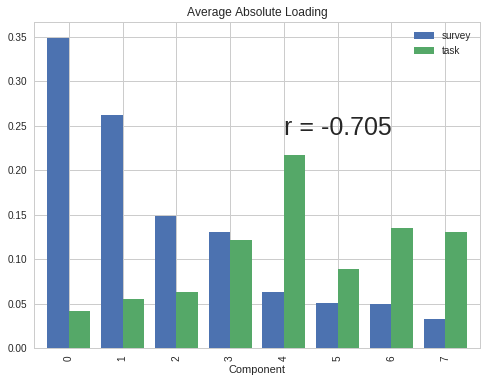

In [151]:
# get absolute average loadings for surveys and tasks per component
abs_survey_loadings = loading_df.filter(regex='survey', axis=0).iloc[:,:best_c].abs().mean()
abs_task_loadings = loading_df.drop(loading_df.filter(regex='survey', axis=0).index, axis=0).iloc[:,:best_c].abs().mean()
abs_average_loadings = pd.concat([abs_survey_loadings, abs_task_loadings],axis=1)
abs_average_loadings.columns = ['survey','task']

# plot
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8,6))
abs_average_loadings.plot(kind='bar',legend=True, width=.8,  ax = ax)
plt.xlabel('Component')
ax.set_title('Average Absolute Loading')
# add correlation of two components to plot
corr = abs_average_loadings.corr().iloc[0,1]
ax.text(4,.24, 'r = %.3f' % corr, fontsize=25)


### Visualize loadings of components on each variable

In [163]:
import numpy as np
import matplotlib.cm as cm
from matplotlib.pyplot import figure, show, rc


# force square figure and square axes looks better for polar, IMO


def plot_loadings(ax,component_loadings, groups):
    colors = sns.hls_palette(len(groups), l=.5, s=.8)
    ax.set_xticklabels([''])
    ax.set_yticklabels([''])
    
    N = len(component_loadings)
    theta = np.arange(0.0, 2*np.pi, 2*np.pi/N)
    radii = abs(component_loadings)
    width = np.pi/(N/2)*np.ones(N)
    bars = ax.bar(theta, radii, width=width, bottom=0.0)
    for i,r,bar in zip(range(N),radii, bars):
        color_index = sum((np.cumsum([len(g[1]) for g in putative_groups])<i))
        bar.set_facecolor(colors[color_index])
        bar.set_alpha(1)
    plt.legend()
    return colors
        
def create_categorical_legend(labels,colors, ax):
    import matplotlib
    descriptions = [g[0] for g in putative_groups]
    def create_proxy(color):
        line = matplotlib.lines.Line2D([0], [0], linestyle='none',
                    mec='none', marker='o', color=color)
        return line
    proxies = [create_proxy(item) for item in colors]
    ax.legend(proxies, labels, numpoints=1, markerscale=2.5, bbox_to_anchor=(1, .5), prop={'size':15})
    
def visualize_factors(loading_df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    loading_df = loading_df.select_dtypes(include=numerics)
    n_components = loading_df.shape[1]
    sns.set_style("white")
    fig = plt.figure(figsize=(20,10))
    for i in range(n_components):
        component_loadings = loading_df.iloc[:,i]
        ax=plt.subplot(2,np.ceil(n_components/2),i+1,polar=True)
        colors = plot_loadings(ax,component_loadings,putative_groups)
    fig.tight_layout()
    create_categorical_legend([g[0] for g in putative_groups],colors,ax)

/home/ian/miniconda3/envs/py34/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


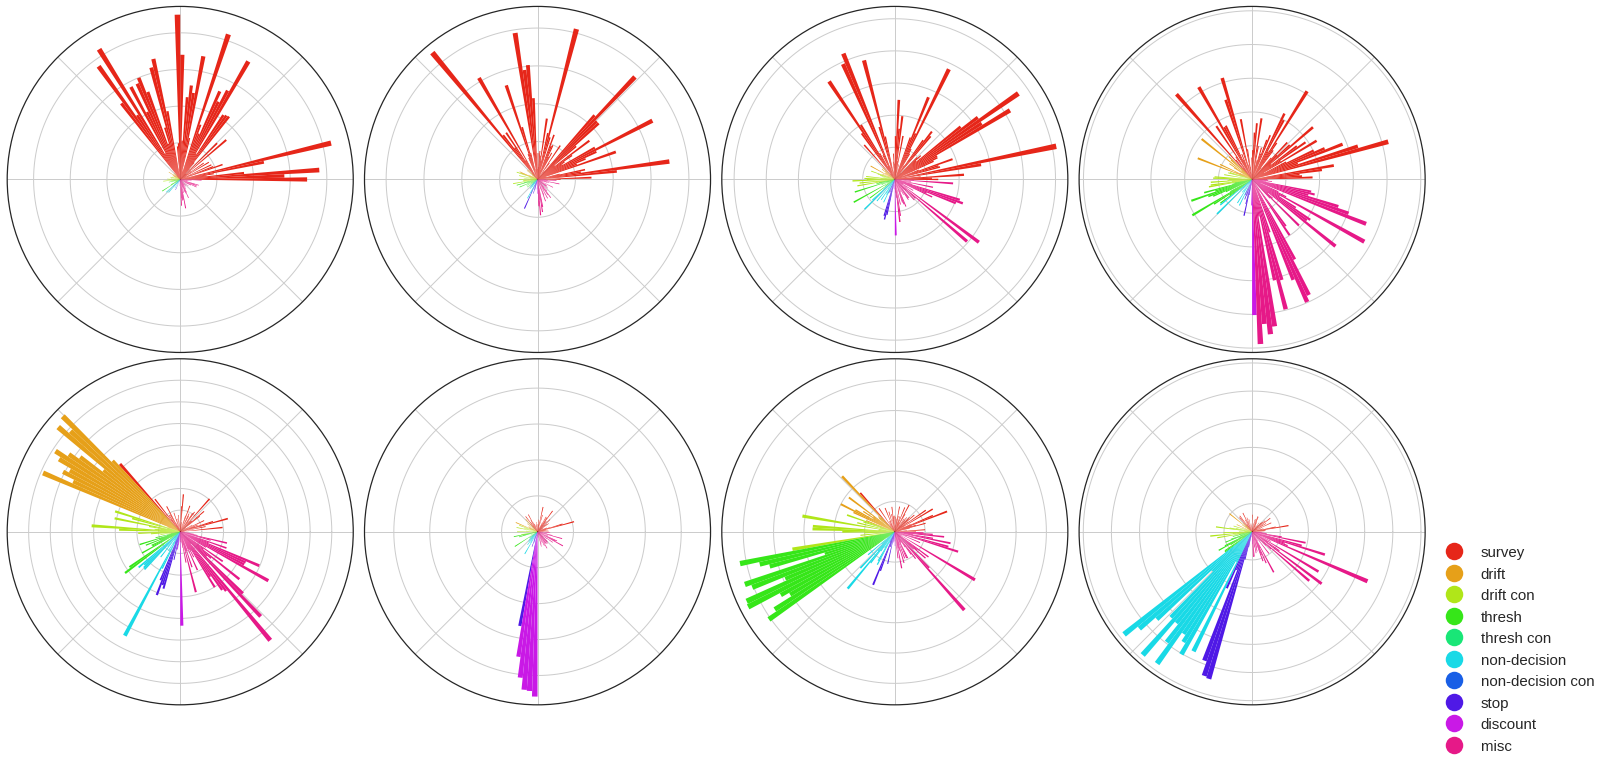

In [164]:
visualize_factors(loading_df)

/home/ian/miniconda3/envs/py34/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


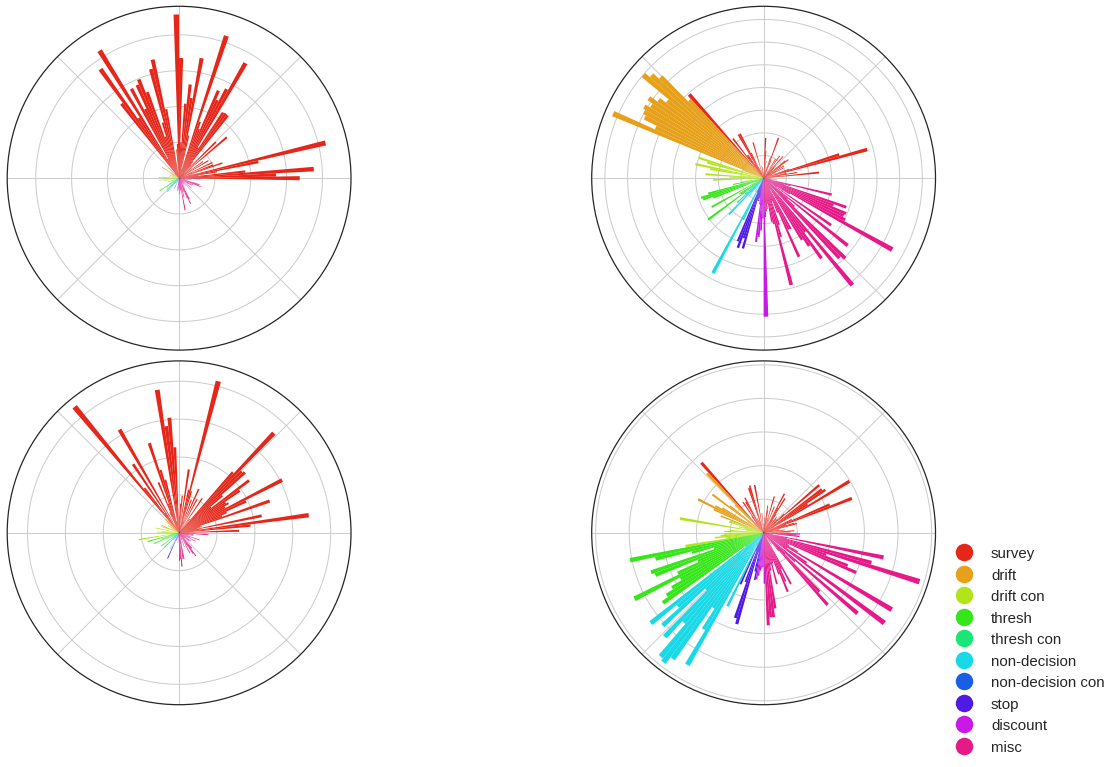

In [178]:
# For other dimensionalities
fa, output = psychFA(data, 4)
loading_df = get_loadings(output, labels=data.columns)
visualize_factors(loading_df)

## Plot relationships between solutions at different dimensionalities

Each factor analytic solution gives us some components. By correlating the components at one level with the next, we can get a sense for how similar these components are. When we move to 3 dimensions from 2, is it the case that one of the dimensions just split? Or is there a new, non-hierarchical parcellation of the space?



In [77]:
# helper functions for plotting dimensionality relations
# compute FA with different dimensionalities and quantify similarity
def dimensional_similarity(factors, reference):
    ''' This function returns an N x M correlation matrix where N is the number
    of reference (lower dimension) factors and M is the number of higher dimension
    factors
    '''
    relation = np.corrcoef(reference.T, factors.T)
    # each row is a reference factor, each column a new factor
    relation=relation[:reference.shape[1], reference.shape[1]:]
    return relation

def construct_relational_tree(similarities, labels=None, filey=None):
    ''' Takes a list of similarities and constructs a tree graph, then plots
    '''
    G = igraph.Graph()
    layer_start = 0
    colors = ['red','blue','green','violet']*10
    for similarity in similarities:
        curr_color = colors.pop()
        origin_length = similarity.shape[0]
        target_length = similarity.shape[1]
        if len(G.vs)==0:
            G.add_vertices(origin_length)
        G.add_vertices(target_length)
        for i in range(origin_length):
            for j in range(target_length):
                G.add_edge(i+layer_start,j+origin_length+layer_start,
                           weight=abs(similarity[i,j]*5),color = curr_color)
        layer_start+=similarity.shape[0]
    layout = G.layout_reingold_tilford(root = [0])
    if labels == None:
        labels = G.vs.indices
    plot = igraph.plot(G, layout=layout, **{'inline': True, 'vertex_label': labels, 
                                            'vertex_color': 'white',
                                            'vertex_size': 20, 
                                         'edge_width':[w for w in G.es['weight']], 
                                         'edge_color': G.es['color'], 
                                            'bbox': (1000,1000), 'margin':100})
    if filey:
        plot.save(filey)
    #G.write_dot('test.dot')
    return G


In [75]:
# construct array of component similarities
similarities = []
components = range(1,20)
reference = None
for c in components:
    fa, output = psychFA(data,c)
    result = pd.DataFrame(output['scores'], data.index)
    if reference is not None:
        similarity = dimensional_similarity(result,reference)
        similarities.append(similarity)
    reference = result




In [66]:
# plot component similarity tree
labels = []
for c in components:
    labels+=factor_names[c]
similarity_tree = construct_relational_tree(similarities, 
                                            labels=None, filey=path.join('Plots', 'task_graph.png'))

NameError: name 'factor_names' is not defined

In [78]:
similarity_tree = construct_relational_tree(similarities, 
                                            labels=None, filey=path.join('Plots', 'task_graph.png'))